*best viewed in [nbviewer](https://nbviewer.jupyter.org/github/CambridgeSemiticsLab/BH_time_collocations/blob/master/results/notebooks/adverbial_components.ipynb)*

# Time Adverbial Components
### Cody Kingham
<a href="../../docs/sponsors.md"><img height=200px width=200px align="left" src="../../docs/images/CambridgeU_BW.png"></a>

In [1]:
! echo "last updated:"; date

last updated:
Tue 26 May 2020 17:11:58 BST


## Introduction

This notebook will produce data for my in-progress article on time adverbial components. 
This notebook will also act as a pathfinder for a refined approach to time adverbial dataset.
As such, we will rely on the modified BHSA data directly rather than using the dataset stored
in `data/main_dataset`.

<hr>

# Python

Now we import the modules and data needed for the analysis.

In [2]:
# standard & data science packages
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.serif'] = ['SBL Biblit']
pd.set_option('display.max_rows', 100)
import seaborn as sns
from bidi.algorithm import get_display # bi-directional text support for plotting

# custom packages (see /tools)
import paths
import stats.significance as mystats
from tf_tools.load import load_tf
from positions import Walker, Positions
import tf_tools.formatting as form

# launch Text-Fabric with custom data
TF, API, A = load_tf('funct_assoc nhead top_assoc', silent='deep')
A.displaySetup(condenseType='phrase')
F, E, T, L = A.api.F, A.api.E, A.api.T, A.api.L # corpus analysis methods

# set paths
from pathlib import Path
x_data_path = paths.data.joinpath('x_dataset/')

def savefig(name):
    """Formats filename and save a figure"""
    file_name = paths.figs.joinpath(f'ta_components/{name}.svg')
    plt.savefig(file_name, format='svg', bbox_inches='tight')

## Pathfinder dataset for all phrase functions

In [3]:
phrase_dataset = []

for phrase in F.otype.s('phrase'):
    
    # exclude Aramaic portions
    lang = F.language.v(L.d(phrase,'word')[0])
    if lang != 'Hebrew':
        continue
    
    book, chapter, verse = T.sectionFromNode(phrase)
    book_sbl = form.book2sbl[book]
    sentence = L.u(phrase, 'sentence')[0]
    ref = f'{form.book2sbl[book]} {chapter}:{verse}'
    function = F.function.v(phrase)
    s_function = form.simplified_functions.get(function, function)
    n_words = len(L.d(phrase, 'word'))
    n_phrase_atoms = len(L.d(phrase, 'phrase_atom'))
    heads = E.nhead.t(phrase)
    n_heads = len(heads)
    head_lexs = '|'.join(F.lex.v(h) for h in heads)
    head_utf8 = '|'.join(T.text(h).strip() for h in heads)
    head_lexnodes = tuple(L.u(h,'lex')[0] for h in heads)
    daughters = E.mother.t(phrase)
    n_daughters = len(daughters)
    d_relas = '|'.join(F.rela.v(d) for d in daughters)
    ph_typ = F.typ.v(phrase)
    rela = F.rela.v(phrase)
    time_phrase = L.u(phrase, 'timephrase')
    
    phrase_dataset.append({
        'node': phrase,
        'ref': ref,
        'book': book_sbl,
        'text': T.text(phrase),
        'sentence': T.text(sentence),
        'type': ph_typ,
        'function': function,
        's_function': s_function,
        'rela': rela,
        'n_words': n_words,
        'n_phrase_atoms': n_phrase_atoms,
        'n_heads': n_heads,
        'head_lex': head_lexs,
        'head_lex_nodes': head_lexnodes,
        'n_daughters': n_daughters,
        'daught_relas': d_relas or np.nan,
        'in_timephrase': bool(time_phrase),
    })
    
print(len(phrase_dataset), 'phrases collected...')

249382 phrases collected...


In [4]:
phrase_df = pd.DataFrame(phrase_dataset)
phrase_df.set_index('node', inplace=True)

In [5]:
phrase_df.head()

,ref,book,text,sentence,type,function,s_function,rela,n_words,n_phrase_atoms,n_heads,head_lex,head_lex_nodes,n_daughters,daught_relas,in_timephrase
node,,,,,,,,,,,,,,,,
651542,Gen 1:1,Gen,בְּרֵאשִׁ֖ית,בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,PP,Time,Time,NA,2,1,1,R>CJT/,"(1437568,)",0,NaN,True
651543,Gen 1:1,Gen,בָּרָ֣א,בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,VP,Pred,Pred,NA,1,1,1,BR>[,"(1437569,)",0,NaN,False
651544,Gen 1:1,Gen,אֱלֹהִ֑ים,בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,NP,Subj,Subj,NA,1,1,1,>LHJM/,"(1437570,)",0,NaN,False
651545,Gen 1:1,Gen,אֵ֥ת הַשָּׁמַ֖יִם וְאֵ֥ת הָאָֽרֶץ׃,בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,PP,Objc,Objc,NA,7,1,2,CMJM/|>RY/,"(1437573, 1437575)",0,NaN,False
651546,Gen 1:2,Gen,וְ,וְהָאָ֗רֶץ הָיְתָ֥ה תֹ֨הוּ֙ וָבֹ֔הוּ,CP,Conj,Conj,NA,1,1,1,W,"(1437574,)",0,NaN,False


Let's get some phrase statistics in order to see how many simple/complex phrases we have. 
We use a few features to measure "complexity":

    1. number of phrase_atoms
    2. number of heads
    3. number of daughters

In [6]:
n_atoms = phrase_df.n_phrase_atoms.value_counts()
n_heads = phrase_df.n_heads.value_counts()
n_daughts = phrase_df.n_daughters.value_counts()

print('n_atoms')
display(n_atoms)

print('\nn_heads')
display(n_heads)

print('\nn_daughters')
display(n_daughts)

n_atoms


1     239774
2       7342
3       1273
4        472
5        261
6        102
7         58
8         40
9         20
11        15
10        12
12         7
15         2
14         2
16         1
13         1
Name: n_phrase_atoms, dtype: int64


n_heads


1     241834
2       5478
3       1285
4        472
5        144
6         83
7         51
8         15
9          8
10         5
11         3
14         2
12         2
Name: n_heads, dtype: int64


n_daughters


0    244083
1      4986
2       286
3        24
4         2
6         1
Name: n_daughters, dtype: int64

Let's look closer at number of atoms by correlating the counts with
phrase functions. Are there any dependent relationships?

In [7]:
functXatoms = pd.pivot_table(
    phrase_df, 
    index='s_function', 
    columns='n_phrase_atoms',
    aggfunc='size',
).fillna(0)

functXwords = pd.pivot_table(
    phrase_df, 
    index='s_function', 
    columns='n_words',
    aggfunc='size',
).fillna(0)

Let's have a look at the frequencies of the various phrase functions. The corresponding values
for each of the codes is supplied just below.

In [8]:
functXatoms.sum(1).sort_values(ascending=False)

s_function
Pred    62762.0
Conj    45489.0
Subj    31423.0
Cmpl    29568.0
Objc    22394.0
PreC    18922.0
Adju     9404.0
Rela     6167.0
Nega     5960.0
Time     4558.0
Modi     3118.0
Loca     2599.0
Intj     1860.0
Voct     1572.0
Ques     1194.0
Frnt     1111.0
NCop      698.0
PrAd      243.0
Supp      178.0
Exst      140.0
EPPr       14.0
PrcS        8.0
dtype: float64

In [9]:
form.funct2function

{'Adju': 'Adjunct',
 'Cmpl': 'Complement',
 'Conj': 'Conjunction',
 'EPPr': 'Enclitic personal pronoun',
 'ExsS': 'Existence with subject suffix',
 'Exst': 'Existence',
 'Frnt': 'Fronted element',
 'Intj': 'Interjection',
 'IntS': 'Interjection with subject suffix',
 'Loca': 'Location',
 'Modi': 'Modifier',
 'ModS': 'Modifier with subject suffix',
 'NCop': 'Negative copula',
 'NCoS': 'Negative copula with subject suffix',
 'Nega': 'Negation',
 'Objc': 'Object',
 'PrAd': 'Predicative adjunct',
 'PrcS': 'Predicate complement with subject suffix',
 'PreC': 'Predicate complement',
 'Pred': 'Predicate',
 'PreO': 'Predicate with object suffix',
 'PreS': 'Predicate with subject suffix',
 'PtcO': 'Participle with object suffix',
 'Ques': 'Question',
 'Rela': 'Relative',
 'Subj': 'Subject',
 'Supp': 'Supplementary constituent',
 'Time': 'Time',
 'Unkn': 'Unknown',
 'Voct': 'Vocative'}

Let's have a look at the minor cases. Those are the phrase functions 
which have a lower frequency. 

In [10]:
functXatoms.loc[functXatoms.sum(1) < 1000]

n_phrase_atoms,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
s_function,,,,,,,,,,,,,,,,
EPPr,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Exst,140.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NCop,698.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PrAd,224.0,16.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PrcS,5.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Supp,178.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
functXatoms_top = functXatoms.loc[functXatoms.sum(1) > 1000]

functXatoms_top

n_phrase_atoms,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
s_function,,,,,,,,,,,,,,,,
Adju,8636.0,572.0,132.0,23.0,22.0,14.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Cmpl,27595.0,1570.0,242.0,76.0,52.0,11.0,9.0,4.0,3.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0
Conj,45489.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Frnt,933.0,117.0,39.0,12.0,6.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Intj,1860.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Loca,2360.0,179.0,36.0,9.0,10.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Modi,3068.0,46.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Nega,5960.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Objc,20715.0,1152.0,264.0,114.0,76.0,30.0,14.0,13.0,8.0,2.0,3.0,1.0,0.0,1.0,1.0,0.0


In [12]:
desc = functXatoms_top.T.describe()

desc

s_function,Adju,Cmpl,Conj,Frnt,Intj,Loca,Modi,Nega,Objc,PreC,Pred,Ques,Rela,Subj,Time,Voct
count,16.000000,16.000000,16.0000,16.000000,16.00,16.000000,16.000000,16.0,16.000000,16.000000,16.000000,16.000000,16.0000,16.000000,16.000000,16.000000
mean,587.750000,1848.000000,2843.0625,69.437500,116.25,162.437500,194.875000,372.5,1399.625000,1182.625000,3922.625000,74.625000,385.4375,1963.937500,284.875000,98.250000
std,2150.955183,6876.891478,11372.2500,232.198469,465.00,587.704798,766.251906,1490.0,5158.713921,4386.483267,15682.767808,298.233438,1541.7500,7124.844611,1049.387432,346.255301
min,0.000000,0.000000,0.0000,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000
25%,0.000000,0.750000,0.0000,0.000000,0.00,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.0000,3.250000,0.000000,0.000000
50%,1.000000,3.500000,0.0000,0.000000,0.00,0.500000,0.000000,0.0,10.500000,2.500000,0.000000,0.000000,0.0000,13.500000,0.500000,0.000000
75%,22.250000,58.000000,0.0000,7.500000,0.00,9.250000,0.250000,0.0,85.500000,44.250000,0.250000,0.000000,0.0000,73.250000,12.750000,1.000000
max,8636.000000,27595.000000,45489.0000,933.000000,1860.00,2360.000000,3068.000000,5960.0,20715.000000,17603.000000,62733.000000,1193.000000,6167.0000,28601.000000,4215.000000,1387.000000


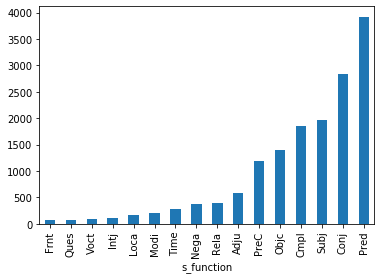

In [13]:
desc.loc['mean'].sort_values().plot(kind='bar')

The IQR can give us a better idea of dispersion.

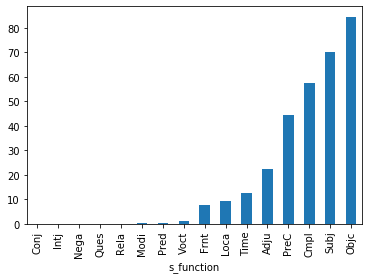

In [14]:
IQR = desc.loc['75%'] - desc.loc['25%'] # Levshina 2015: 49

IQR.sort_values().plot(kind='bar')

Now we can see two clear groups, those ranging from Conjunction to Vocatives,\
and those ranging from Fronted elements to Objects. One might draw a further \
subgroup within the latter, ranging from Adjunct to Objects.

The main thing we're interested in here is whether any of the functions would be\
negatively affected by selecting only single-phrase atom cases. In this case, the\
Object, Subject, and Complement functions have the largest spread and thus are most\
at risk for being affected by such a selection.

That risk is illustrated below by looking at the first and second quartiles.

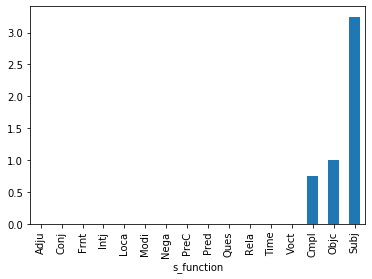

In [15]:
desc.loc['25%'].sort_values().plot(kind='bar')

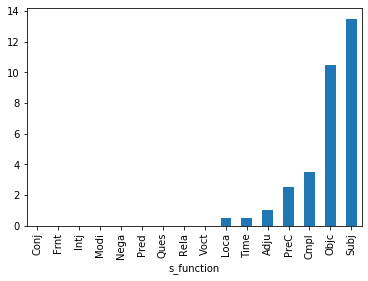

In [16]:
desc.loc['50%'].sort_values().plot(kind='bar')

Let's see what percentage values represent that lie below n_atoms = 1.

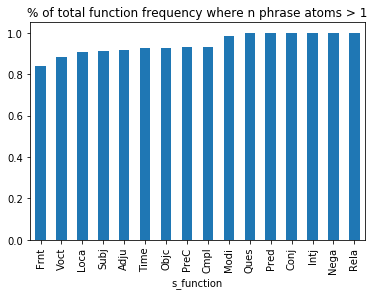

In [17]:
percentages = functXatoms_top[1].div(functXatoms_top.sum(1), 0).sort_values()

plt.figure()
ax = percentages.plot(kind='bar')
ax.set_title('% of total function frequency where n phrase atoms > 1')
plt.show()

In [18]:
percentages

s_function
Frnt    0.839784
Voct    0.882316
Loca    0.908042
Subj    0.910193
Adju    0.918333
Time    0.924748
Objc    0.925025
PreC    0.930293
Cmpl    0.933272
Modi    0.983964
Ques    0.999162
Pred    0.999538
Conj    1.000000
Intj    1.000000
Nega    1.000000
Rela    1.000000
dtype: float64

We can see here that the vast majority of functions have only one\
phrase atom. The types that stand to lose the largest proportions of\
their representative examples are:

In [19]:
largest_loss = percentages[percentages < 0.98]

largest_loss

s_function
Frnt    0.839784
Voct    0.882316
Loca    0.908042
Subj    0.910193
Adju    0.918333
Time    0.924748
Objc    0.925025
PreC    0.930293
Cmpl    0.933272
dtype: float64

However, these proportions are mostly negligible. However, the\
Fronted function is affected quite a bit ($16\%$)

In [20]:
1 - largest_loss 

s_function
Frnt    0.160216
Voct    0.117684
Loca    0.091958
Subj    0.089807
Adju    0.081667
Time    0.075252
Objc    0.074975
PreC    0.069707
Cmpl    0.066728
dtype: float64

The vocative is also negatively affected. Note that there is a drop-off after\
the vocative function, ranging from Location to Complements. It seems reasonable\
to consider this a cut-off point, taking those functions after the vocatives, which\
from then on are only affected by a <= 9% loss.

Those that will lose very little of their overall representation are:

In [21]:
smallest_loss = percentages[percentages > 0.98]

smallest_loss

s_function
Modi    0.983964
Ques    0.999162
Pred    0.999538
Conj    1.000000
Intj    1.000000
Nega    1.000000
Rela    1.000000
dtype: float64

In [22]:
1 - smallest_loss

s_function
Modi    0.016036
Ques    0.000838
Pred    0.000462
Conj    0.000000
Intj    0.000000
Nega    0.000000
Rela    0.000000
dtype: float64

However, some of these functions represent negligible proportions of\
of all functions with single phrase atoms:

In [23]:
total_percent = functXatoms_top[1].div(functXatoms_top.sum().sum(), 0).sort_values()

total_percent

s_function
Frnt    0.003761
Ques    0.004809
Voct    0.005590
Intj    0.007497
Loca    0.009512
Modi    0.012366
Time    0.016989
Nega    0.024022
Rela    0.024857
Adju    0.034808
PreC    0.070951
Objc    0.083494
Cmpl    0.111225
Subj    0.115280
Conj    0.183349
Pred    0.252853
Name: 1, dtype: float64

In [24]:
loss2total = pd.concat([percentages, total_percent], 1, sort=True)
loss2total.columns=['% kept', '% total']
loss2total

,% kept,% total
Adju,0.918333,0.034808
Cmpl,0.933272,0.111225
Conj,1.000000,0.183349
Frnt,0.839784,0.003761
Intj,1.000000,0.007497
Loca,0.908042,0.009512
Modi,0.983964,0.012366
Nega,1.000000,0.024022
Objc,0.925025,0.083494
PreC,0.930293,0.070951


In [25]:
total_percent

s_function
Frnt    0.003761
Ques    0.004809
Voct    0.005590
Intj    0.007497
Loca    0.009512
Modi    0.012366
Time    0.016989
Nega    0.024022
Rela    0.024857
Adju    0.034808
PreC    0.070951
Objc    0.083494
Cmpl    0.111225
Subj    0.115280
Conj    0.183349
Pred    0.252853
Name: 1, dtype: float64

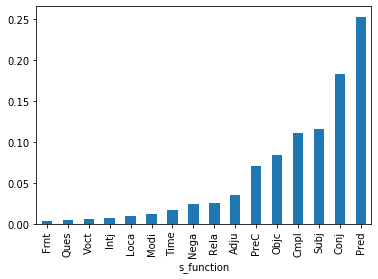

In [26]:
total_percent.plot(kind='bar')

It seems reasonable going forward to exclude such functions as:

    Fronted, lots of loss, small
    Vocative, lots of loss, small
    Question, small
    Interjection, small

In [27]:
exclude_functions = [
    'Frnt', 'Voct', 'Ques', 'Intj'
]

In [28]:
functXatoms2 = functXatoms_top.loc[~functXatoms_top.index.isin(exclude_functions)]

functXatoms2

n_phrase_atoms,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
s_function,,,,,,,,,,,,,,,,
Adju,8636.0,572.0,132.0,23.0,22.0,14.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Cmpl,27595.0,1570.0,242.0,76.0,52.0,11.0,9.0,4.0,3.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0
Conj,45489.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Loca,2360.0,179.0,36.0,9.0,10.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Modi,3068.0,46.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Nega,5960.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Objc,20715.0,1152.0,264.0,114.0,76.0,30.0,14.0,13.0,8.0,2.0,3.0,1.0,0.0,1.0,1.0,0.0
PreC,17603.0,1052.0,131.0,72.0,35.0,14.0,8.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
Pred,62733.0,24.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
list(functXatoms2.index)

['Adju',
 'Cmpl',
 'Conj',
 'Loca',
 'Modi',
 'Nega',
 'Objc',
 'PreC',
 'Pred',
 'Rela',
 'Subj',
 'Time']

We can also build another group, representing those phrase functions noted\
earlier which have more of a spread across n-atoms, and are thus more similar\
to the time phrase:

In [30]:
like_time_sample = [
    'Loca', 'Subj', 'Adju',
    'Time', 'Objc', 'PreC',
    'Cmpl'
]

It's probably no coincidence these phrase functions are more similar\
in their spread of number of phrase atoms, since these more noun-based\
phrase types. Let's briefly confirm that.

In [31]:
functXtype = pd.pivot_table(
    phrase_df[phrase_df.n_phrase_atoms == 1], 
    index=['s_function'], 
    columns=['type'], 
    aggfunc='size'
).fillna(0)

In [32]:
functXtype

type,AdjP,AdvP,CP,DPrP,IPrP,InjP,InrP,NP,NegP,PP,PPrP,PrNP,VP
s_function,,,,,,,,,,,,,
Adju,0.0,0.0,0.0,0.0,0.0,0.0,0.0,352.0,0.0,8284.0,0.0,0.0,0.0
Cmpl,0.0,749.0,0.0,0.0,0.0,0.0,7.0,477.0,0.0,26077.0,0.0,285.0,0.0
Conj,0.0,0.0,45489.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EPPr,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0
Exst,0.0,0.0,0.0,0.0,0.0,0.0,0.0,140.0,0.0,0.0,0.0,0.0,0.0
Frnt,0.0,1.0,0.0,17.0,5.0,0.0,0.0,618.0,0.0,127.0,104.0,61.0,0.0
Intj,0.0,0.0,0.0,0.0,0.0,1860.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Loca,0.0,375.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,1864.0,0.0,21.0,0.0
Modi,0.0,3000.0,0.0,0.0,0.0,0.0,0.0,65.0,0.0,3.0,0.0,0.0,0.0


In [33]:
functXtype_percent = functXtype.div(functXtype.sum(1), 0)

functXtype_percent

type,AdjP,AdvP,CP,DPrP,IPrP,InjP,InrP,NP,NegP,PP,PPrP,PrNP,VP
s_function,,,,,,,,,,,,,
Adju,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.040760,0.0,0.959240,0.000000,0.000000,0.000000
Cmpl,0.000000,0.027143,0.000000,0.000000,0.000000,0.0,0.000254,0.017286,0.0,0.944990,0.000000,0.010328,0.000000
Conj,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
EPPr,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000
Exst,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000
Frnt,0.000000,0.001072,0.000000,0.018221,0.005359,0.0,0.000000,0.662379,0.0,0.136120,0.111468,0.065380,0.000000
Intj,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
Loca,0.000000,0.158898,0.000000,0.000000,0.000000,0.0,0.000000,0.042373,0.0,0.789831,0.000000,0.008898,0.000000
Modi,0.000000,0.977836,0.000000,0.000000,0.000000,0.0,0.000000,0.021186,0.0,0.000978,0.000000,0.000000,0.000000


### Look at a range of selections at once

We look at how all of the potential selection parameters can affect the dataset at once.<br>
That data will be displayed in a set of subgraphs.

Steps to do, with key functions:
    
    plot pivot table for n_phrase heads == 1 versus all
    plot pivot table for n_daughter relations == 0
    plot pivot table for combined n_phrase and n_daughter rules
    plot degree of dispersion n_phrase heads == 1 versus n_phrase heads == x
    plot degree of dispersion n_phrase & n_daughter rules, additional rules?
    
display all in one plot?

In [34]:
# store settings to build all tables
table_settings = {
    'n_atoms': {
        'cols': ['n_phrase_atoms'],
        'sum_column': 1,
        'new_cols': ('na = 1', 'na > 1'),
    },
    'n_heads': {
        'cols': ['n_heads'],
        'sum_column': 1,
        'new_cols': ('nh = 1', 'nh > 1')
    },
    'n_childs': {
        'cols': ['n_daughters'],
        'sum_column': 0,
        'new_cols': ('nd = 0', 'nd > 0'),
    },
    'n_all': {
        'cols': ['n_phrase_atoms', 'n_heads', 'n_daughters'],
        'sum_column': (1, 1, 0),
        'new_cols': ('na=1 + nh=1 + nd=0', 'na>1 + nh>1 + nd>0'),
    }
}

# define sample
functions_sample = sorted([
    'Adju',
    'Cmpl',
    'Conj',
    'Loca',
    'Modi',
    'Nega',
    'Objc',
    'PreC',
    'Pred',
    'Rela',
    'Subj',
    'Time',
])
funct_sample = phrase_df[phrase_df.s_function.isin(functions_sample)]

pivots = {}
for name, setting in table_settings.items():
    
    # build pivot tables that count all of the set columns
    # as they appear together
    pivots[name] = pd.pivot_table(
        funct_sample, 
        index='s_function',
        columns=setting['cols'],
        aggfunc='size',
        fill_value=0,
    )

    
# make summaries 
sums = {}

for name, setting in table_settings.items():
    pivot = pivots[name]
    first_sum = pivot[setting['sum_column']]
    second_sum = pivot.drop(columns=setting['sum_column']).sum(1)    
    new_table = pd.concat([first_sum, second_sum], 1)
    new_table.columns = setting['new_cols']
    sums[name] = new_table
    
    
props = {}
for name, table in sums.items():
    props[name] = table.div(table.sum(1), 0)
    
props.keys()

dict_keys(['n_atoms', 'n_heads', 'n_childs', 'n_all'])

Make the subplots.

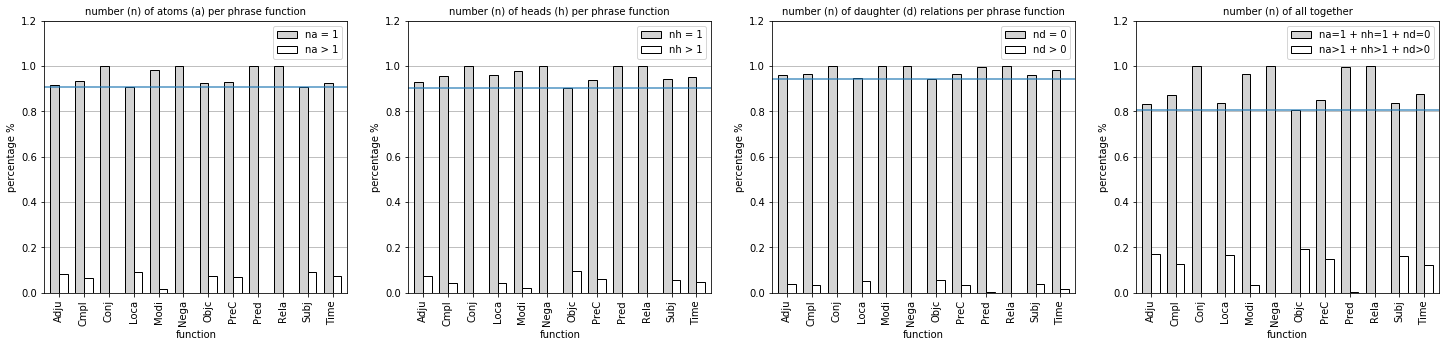

In [35]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25, 5))

props['n_atoms'].plot(kind='bar', ax=ax1, color=['lightgrey', 'white'], edgecolor='black', width=0.7)
ax1.axhline(props['n_atoms']['na = 1'].min(), alpha=0.8)
ax1.set_title('number (n) of atoms (a) per phrase function', size=10)

props['n_heads'].plot(kind='bar', ax=ax2, color=['lightgrey', 'white'], edgecolor='black', width=0.7)
ax2.axhline(props['n_heads']['nh = 1'].min(), alpha=0.8)
ax2.set_title('number (n) of heads (h) per phrase function', size=10)

props['n_childs'].plot(kind='bar', ax=ax3, color=['lightgrey', 'white'], edgecolor='black', width=0.7)
ax3.axhline(props['n_childs']['nd = 0'].min(), alpha=0.8)
ax3.set_title('number (n) of daughter (d) relations per phrase function', size=10)

props['n_all'].plot(kind='bar', ax=ax4, color=['lightgrey', 'white'], edgecolor='black', width=0.7)
ax4.axhline(props['n_all']['na=1 + nh=1 + nd=0'].min(), alpha=0.8)
ax4.set_title('number (n) of all together', size=10)

for ax in (ax1, ax2, ax3, ax4):
    ax.set_ylim(0, 1.2)
    ax.grid(axis='y')
    ax.set_axisbelow(True) 
    ax.set_xlabel('function', size=10)
    ax.set_ylabel('percentage %', size=10)
    ax.set_xticklabels(ax.get_xticklabels(), size=10)
    
savefig('funct_sample')

In [36]:
props['n_all'].T.sort_values(by='na=1 + nh=1 + nd=0', axis=1)

s_function,Objc,Adju,Loca,Subj,PreC,Cmpl,Time,Modi,Pred,Rela,Conj,Nega
na=1 + nh=1 + nd=0,0.808252,0.831242,0.835321,0.837539,0.852658,0.874324,0.876042,0.96408,0.997945,0.999514,0.999978,1.0
na>1 + nh>1 + nd>0,0.191748,0.168758,0.164679,0.162461,0.147342,0.125676,0.123958,0.03592,0.002055,0.000486,0.000022,0.0


We can note that all phrase functions have retained at least 81% of their total instances.\
The "worst" affected is the Object phrase, with 19% of its forms excluded by the additional
requirements.

## Deviation of Proportions

Now we'll look to see how representative the datasample is accross the<br>
Hebrew Bible. Have the selection requirements negatively affected any of the books?

In [37]:
# make a cross-tabulation from function to 
# book, n_pa, n_heads, and n_daughters to 
# enable selection of data as needed

by_book = pd.pivot_table(
    funct_sample, 
    index='s_function', 
    columns=['n_phrase_atoms', 'n_heads', 'n_daughters', 'book'], 
    aggfunc='size', 
    fill_value=0
)

by_book.head()

n_phrase_atoms    1                                                      ...  \
n_heads            1                                                     ...   
n_daughters        0                                                     ...   
book           1 Chr 1 Kgs 1 Sam 2 Chr 2 Kgs 2 Sam Amos  Dan  Deut Eccl  ...   
s_function                                                               ...   
Adju             326   224   138   381   183   197   45   80   286   71  ...   
Cmpl             534  1102  1514  1000  1122  1075  205  209  1265  181  ...   
Conj            1424  2097  2635  2055  2025  1999  334  496  1933  455  ...   
Loca              51   101    74    92   102    79   29    9   137   39  ...   
Modi              35   121   141    86    95   109   42   10   110   41  ...   

n_phrase_atoms    12                  13    14          15      16  
n_heads            4             5     4     5           1   6   6  
n_daughters        0             0     0     0           0   0   0  
book           1 Kgs 2 Chr Jer Gen 2 Kgs 1 Chr 2 Kgs 2 Chr Jer Jer  
s_function                                                          
Adju               0     0   0   0     0     0     0     0   0   0  
Cmpl               1     0   0   0     0     0     0     0   0   0  
Conj               0     0   0   0     0     0     0     0   0   0  
Loca               0     0   0   0     0     0     0     0   0   0  
Modi               0     0   0   0     0     0     0     0   0   0  

[5 rows x 1148 columns]

### Does the sample selection affect book-by-book representation of functions?

In [38]:
# exp_prop is a table of ratios which state 
# what proportion of a function's total uses is represented within a given book
# the observed proportion will be that subset of phrases that fit our selection
# criteria, i.e. na=1, nh=1, nd=0
exp_freq = by_book.groupby(axis=1, level='book').sum()
exp_prop = exp_freq.div(exp_freq.sum(1), 0)

# observed proportion is the ratio of the selected sample function's
# total representation within a given book: in this case only functions
# which have 1 atom, 1 head, and 0 daughters
obv_freq = by_book[(1, 1, 0)]
obv_prop = obv_freq.div(obv_freq.sum(1), 0)

# the deviation of proportions will be the DIFFERENCE between the expected ratios 
# (calculated across the whole dataset) and the ratios across the selected subset
# of phrases
deviation_prop = round(exp_prop - obv_prop, 2)

In [39]:
deviation_prop.mean(1)

s_function
Adju   -0.000256
Cmpl    0.000000
Conj    0.000000
Loca    0.000256
Modi    0.000256
Nega    0.000000
Objc   -0.000513
PreC    0.000769
Pred    0.000000
Rela    0.000000
Subj    0.000256
Time    0.000000
dtype: float64

In [40]:
deviation_prop.mean(0)

book
1 Chr    0.001667
1 Kgs    0.000000
1 Sam    0.000000
2 Chr    0.001667
2 Kgs    0.000000
2 Sam    0.000000
Amos     0.000000
Dan      0.000000
Deut     0.002500
Eccl     0.000000
Esth     0.000000
Exod     0.000000
Ezek     0.000833
Ezra     0.000000
Gen     -0.000833
Hab      0.000000
Hag      0.000000
Hos      0.000000
Isa     -0.001667
Jer      0.000000
Job     -0.001667
Joel     0.000000
Jonah    0.000000
Josh     0.001667
Judg     0.000000
Lam      0.000000
Lev      0.000000
Mal      0.000000
Mic      0.000000
Nah      0.000000
Neh      0.000000
Num      0.001667
Obad     0.000000
Prov    -0.000833
Ps      -0.002500
Ruth     0.000000
Song     0.000000
Zech     0.000000
Zeph     0.000000
dtype: float64

**Based on this data, we can say that the filtered selection of phrase functions<br>
does not negatively affect representation across the Hebrew Bible. The deviation<br>
of proportions is very small across both book and function categories.**

### How evenly distributed is Time compared to the other key functions? (DP)

We can answer this question using DP (Gries 2008), the Degree of Dispersion.<br>

For a given sample (e.g. Hebrew Bible), divide the sample into its various parts (books).<br> 
Use a baseline (e.g. n-phrases) to calculate what proportion each part *should* account<br>
for in the dataset. And compare the observed proportion for a given variable (in this case<br>
function).

In [41]:
# expected proportional representation of total number 
# of phrases for any given book; retrieved by dividing 
# a book's total phrases by the marginal total of all books' n-phrases
book_exp_props = exp_freq.sum(0) / exp_freq.sum(0).sum()

# observed proportional representation for any given book
# of a given function's total occurrences
book_obv_prop = exp_freq.div(exp_freq.sum(1), 0)

# calculate the deviation of proportion of the observed
# proportional representation from the expected proportion
book_dev_prop = book_obv_prop.sub(book_exp_props, 1)

# calculate DP score following Gries 2008 by summing absolute
# value of all deviations per function and dividing by 2
# the resulting score ranges from 0 to 1 where 0 is the 
# hypothetical perfectly distributed function and 1 is the 
# hypothetical worst distributed function
DP = abs(book_dev_prop).sum(1) / 2
DP = DP.sort_values()

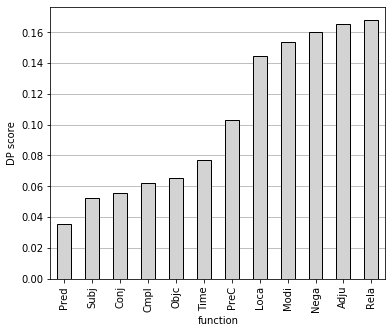

In [42]:
fig, ax = plt.subplots(figsize=(6,5))
DP.plot(kind='bar', ax=ax, color='lightgrey', edgecolor='black')
ax.set_xlabel('function')
ax.set_ylabel('DP score')
ax.grid(axis='y')
ax.set_axisbelow(True) 
savefig('DP_functions')
plt.show()

Show deviation of proportions for Time function.

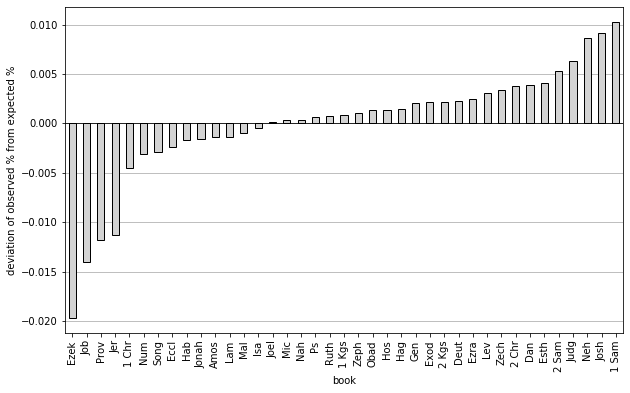

In [43]:
fig, ax = plt.subplots(figsize=(10, 6))
book_dev_prop.loc['Time'].sort_values().plot(kind='bar', ax=ax, color='lightgray', edgecolor='black')
ax.axhline(0, color='black', linewidth=0.8)
ax.grid(axis='y')
ax.set_axisbelow(True) 
ax.set_ylabel('deviation of observed % from expected %', size=10)
savefig('deviation_%_time')
plt.show()

## Function Head Associations

We'll now measure head-word associations accross functions. We make the selection<br>
requirement for the dataset that phrases have 1 phrase atom, 1 head word, 0 daughter<br>
relations.

We make the further requirement to only example the select subsample of phrase functions<br>
analyzed above.

In [44]:
phrase_sample = funct_sample[
    (funct_sample.n_phrase_atoms == 1) &
    (funct_sample.n_heads == 1) &
    (funct_sample.n_daughters == 0)
]

phrase_sample.shape

(223636, 16)

## How predictive is a given headword of various functions?

Now we make a cross-tabulation between given lex nodes and phrase functions.<br>

The head lexeme will be the independent variable in this case, as we will seek to<br>
answer whether choice of head lexeme is predictive of a given function.

In [45]:
head2funct = pd.pivot_table(
    phrase_sample,
    index='head_lex',
    columns='s_function',
    aggfunc='size',
    fill_value=0
)

head2funct.head()

s_function,Adju,Cmpl,Conj,Loca,Modi,Nega,Objc,PreC,Pred,Rela,Subj,Time
head_lex,,,,,,,,,,,,
<B/,6,6,0,0,0,0,3,1,0,0,7,0
<B=/,0,0,0,0,0,0,0,0,0,0,1,0
<B==/,0,1,0,0,0,0,0,0,0,0,0,0
<BC[,0,0,0,0,0,0,0,0,1,0,0,0
<BD/,21,88,0,0,0,0,42,72,0,0,146,0


### Apply ΔP (Ellis 2006)

ΔP is a measure of predictivity when supplied with a given cue for a given<br>
response. In this case, the head lexeme is the cue, while the function is<br>
the response.

ΔP returns a value between -1 to 1, wherein -1 is the least associated and 1<br>
is the most associated.

In [46]:
delta_p = mystats.apply_deltaP(head2funct, sample_axis=0, feature_axis=1)

delta_p.head()

s_function,Adju,Cmpl,Conj,Loca,Modi,Nega,Objc,PreC,Pred,Rela,Subj,Time
head_lex,,,,,,,,,,,,
<B/,0.225939,0.145286,-0.203423,-0.009709,-0.013443,-0.026653,0.049505,-0.028669,-0.280096,-0.027565,0.186685,-0.017857
<B=/,-0.034954,-0.115599,-0.203403,-0.009708,-0.013442,-0.026651,-0.080935,-0.072144,-0.280068,-0.027563,0.882322,-0.017855
<B==/,-0.034954,0.884405,-0.203403,-0.009708,-0.013442,-0.026651,-0.080935,-0.072144,-0.280068,-0.027563,-0.117683,-0.017855
<BC[,-0.034954,-0.115599,-0.203403,-0.009708,-0.013442,-0.026651,-0.080935,-0.072144,0.719937,-0.027563,-0.117683,-0.017855
<BD/,0.021993,0.123087,-0.203738,-0.009724,-0.013464,-0.026694,0.032940,0.123181,-0.280530,-0.027608,0.278441,-0.017884


Now we need to measure the median tendencies across functions. The question is:<br>
**Which functions have the least/greatest median predictability?**

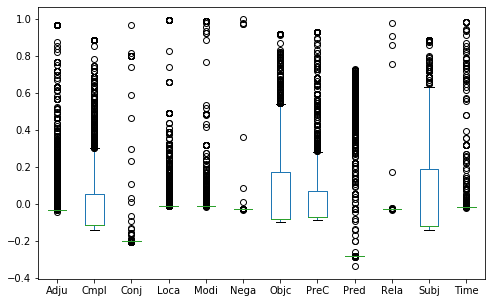

In [47]:
fix, ax = plt.subplots(figsize=(8, 5))
delta_p.plot(kind='box', ax=ax)

Note that a simple boxplot shows a lot of outlieres for certain functions.<br>
This is because there is no even distribution of values for these functions,<br>
but rather a small subset of terms that exhibit strong tendencies.

To better quantify strong associations, we need to make some additional selections<br>
from the dataset.

In [48]:
delta_p[delta_p > 0.2].mean(skipna=True)

s_function
Adju    0.585646
Cmpl    0.559587
Conj    0.697761
Loca    0.494331
Modi    0.672179
Nega    0.856563
Objc    0.579456
PreC    0.626449
Pred    0.623478
Rela    0.872934
Subj    0.572482
Time    0.627248
dtype: float64

In [49]:
delta_p[delta_p > 0.2].mean(skipna=True).sort_values(ascending=False)

s_function
Rela    0.872934
Nega    0.856563
Conj    0.697761
Modi    0.672179
Time    0.627248
PreC    0.626449
Pred    0.623478
Adju    0.585646
Objc    0.579456
Subj    0.572482
Cmpl    0.559587
Loca    0.494331
dtype: float64

In [50]:
delta_p[delta_p > 0]['Subj'].value_counts().size

483

In [51]:
delta_p['Time'][delta_p['Time'] > 0.20].value_counts

<bound method IndexOpsMixin.value_counts of head_lex
<D/        0.674531
<FJRJ/     0.232158
<JLWM/     0.982149
<RB/       0.827865
<T/        0.628653
<TH        0.833348
<WD/       0.743725
<WLM/      0.694922
>CMRT/     0.982158
>CMWRH/    0.315483
>MC/       0.782163
>N         0.759984
>TMWL/     0.815500
>XR/       0.222566
>Z         0.910243
>ZJ        0.982154
BQR=/      0.748895
CBJ<J/     0.357158
CBW</      0.393940
CLCWM/     0.982149
CLWXJM/    0.315483
CNH/       0.614345
CNJ/       0.567615
DMJ=/      0.982149
GZ/        0.315483
JRX/       0.553591
JWM/       0.760707
JWMM       0.982255
JYQH/      0.982149
LJL/       0.315487
LJLH/      0.851145
MBWL/      0.315491
MHRH/      0.871104
MTJ        0.788706
MW<D/      0.238597
MWT/       0.254985
MXR/       0.931025
MXRT/      0.945222
N<WRJM/    0.267885
NCP/       0.357158
NYX/       0.682267
P<M/       0.664225
PT>M       0.940579
QJY/       0.732158
QYT/       0.482149
R>CWN/     0.217505
RG</       0.573111
TCWBH/ 

In [52]:
deltap_average = {}

for function in delta_p.columns:
    data = delta_p[function]
    top_data = data[data > 0.20]
    deltap_average[function] = top_data.mean()

In [53]:
dp_averages = pd.DataFrame.from_dict(deltap_average, orient='index')
dp_averages = dp_averages.sort_values(by=0)

dp_averages

,0
Loca,0.494331
Cmpl,0.559587
Subj,0.572482
Objc,0.579456
Adju,0.585646
Pred,0.623478
PreC,0.626449
Time,0.627248
Modi,0.672179
Conj,0.697761
